<a href="https://colab.research.google.com/github/hadwin-357/ML_models/blob/main/Pytorch_paper_replicating_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torchvision
assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 2.2.1+cu121
torchvision version: 0.17.1+cu121


In [4]:
# Continue with regular imports
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 31.43 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [7]:
train_dir = image_path/"train"
test_dir =image_path/"test"

In [8]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

BATCH_SIZE =32
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir =test_dir,
    transform = manual_transforms,
    batch_size=BATCH_SIZE
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7d343d60e110>,
 ['pizza', 'steak', 'sushi'])

In [9]:
# visualize one image
image_batch, label_batch = next(iter(train_dataloader))
image, label=image_batch[0], label_batch[0]
image.shape,label

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(torch.Size([3, 224, 224]), tensor(2))

(-0.5, 223.5, 223.5, -0.5)

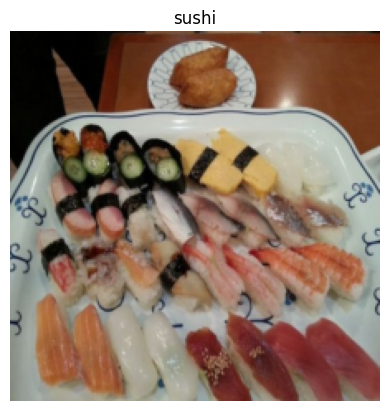

In [10]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

# ViT paper
1. make a picture into patches
2. align pathes into 1D vector
3. using Conv2d to embed feature for patches

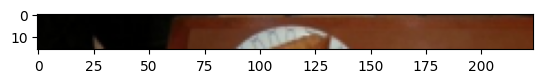

In [11]:
# illustrate code with one example
patch_size=16
N_path = int(224*224/(16*16))
image_permuted= image.permute(1, 2, 0)
# first lane
plt.imshow(image_permuted[:16,:,:])

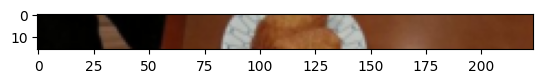

In [12]:
# second lane
plt.imshow(image_permuted[16:32,:,:])

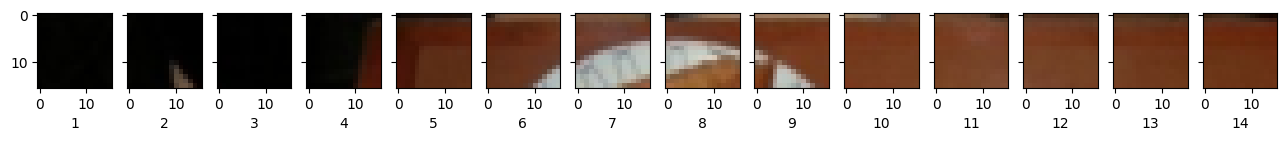

In [13]:
#divide each lane into 16*16 patch
img_size = 224
patch_size = 16
num_patches = int(img_size/patch_size)
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
fig ,axs = plt.subplots(nrows=1,
                        ncols=num_patches,
                        figsize=(16,16),
                        sharex=True,
                        sharey=True)

for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:16,patch:patch+patch_size, :])
  axs[i].set_xlabel(i+1)


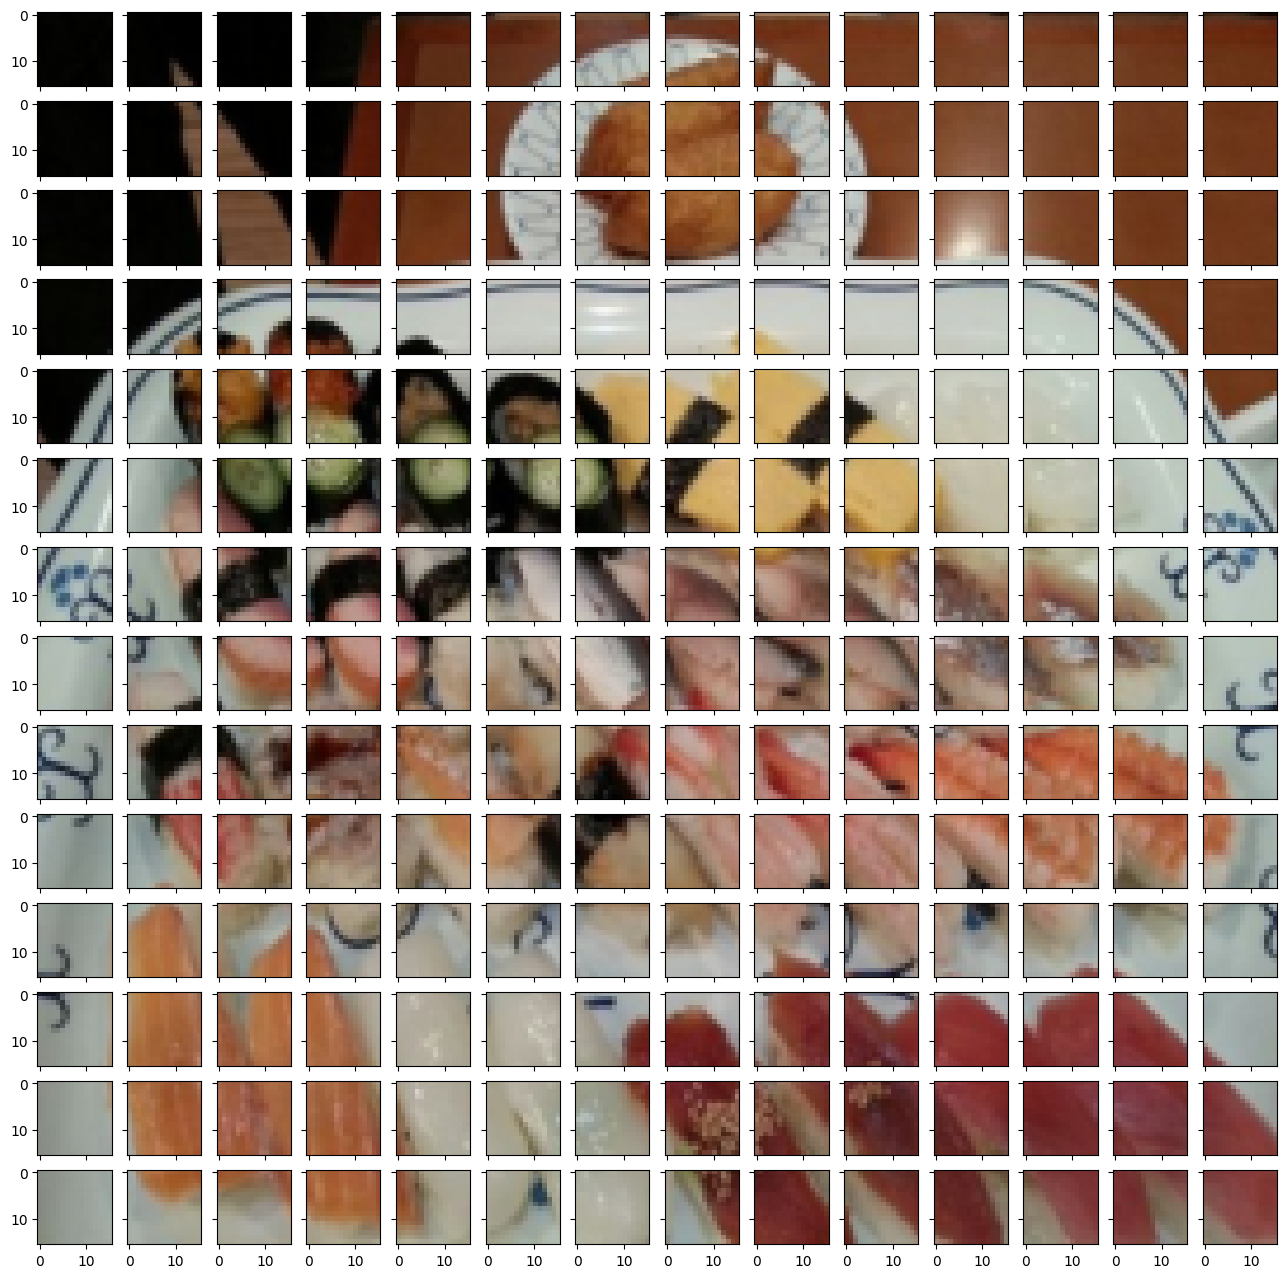

In [14]:
# now divide the image into 14 * 14 patches
fig ,axs = plt.subplots(nrows=num_patches,
                        ncols=num_patches,
                        figsize=(16,16),
                        sharex=True,
                        sharey=True)

for i, patch_x in enumerate(range(0, img_size, patch_size)):
  for j, patch_y in enumerate(range(0, img_size, patch_size)):

    axs[i, j].imshow(image_permuted[patch_x:patch_x+patch_size,patch_y:patch_y+patch_size,:])


In [15]:
# we will use Conv2d to make this patch
kernel_size=16
stride=16
#input size (224*224*3)
#output size (14*14* (16*16*3)=768)
#flatten to (196, 768)

conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

In [16]:
image_out_of_conv=conv2d(image.unsqueeze(0)) # adding batch dimension
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


In [17]:
#then flatten (14, 14) into (196, 1)
# Create flatten layer
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

image_after_flatten=flatten(image_out_of_conv)
print(image_after_flatten.shape)

torch.Size([1, 768, 196])


(-0.5, 767.5, 0.5, -0.5)

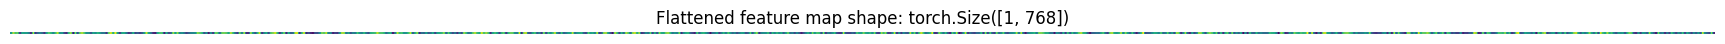

In [18]:
# Get a single flattened feature map
single_flattened_feature_map = image_after_flatten[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False)

In [19]:
#assemby all together to generate class for creating feature

class PatchEmbedding (nn.Module):
  '''Turn 2D images into 1D learnable embedding, 1D of 196 patches with 768 dimension embedding (196, 768)
  Args:
  in_channels(int): 3, RGB
  patch_size (int):16
  embedding_dim(int):
  '''
  def __init__(self,
               in_channels: int=3,
               patch_size: int=16,
               embedding_dim: int=768):
    super().__init__()

    self.patcher =nn.Conv2d(
        in_channels=in_channels,
        out_channels=embedding_dim,
        kernel_size=patch_size,
        stride=patch_size,
        padding=0
    )
    self.flatten=nn.Flatten(start_dim=2,
                            end_dim=3)

  def forward(self,x):
    image_resolution=x.shape[-1]
    assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

    x_patched=self.patcher(x)
    x_flattened =self.flatten(x_patched)
    return x_flattened.permute(0, 2, 1)  # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [20]:
#testing
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [21]:
# Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
random_input_image = (1, 3, 224, 224)
summary(PatchEmbedding(),
        input_size=random_input_image, # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

In [22]:
#next step: generate class embedding
batch_size = patch_embedded_image.shape[0]

embedding_dimension=patch_embedded_image.shape[-1]

class_token=nn.Parameter(torch.randn(batch_size, 1, embedding_dimension), requires_grad=True)
print(class_token[:,:,:10])

#concatenate class embedding to patch embedding

patched_embedding_with_class_embedding=torch.cat((class_token,patch_embedded_image), dim=1)
print(patched_embedding_with_class_embedding.shape)


tensor([[[ 1.2665, -0.9377,  0.2764, -0.9997,  0.5845, -0.4860, -0.4894,
          -1.9987,  0.5642,  0.5950]]], grad_fn=<SliceBackward0>)
torch.Size([1, 197, 768])


In [23]:
#next: create learnable position embedding: it needs to be [197, 768] in demensionality

position_embedding=nn.Parameter(torch.randn(batch_size,patched_embedding_with_class_embedding.shape[1],
                                           patched_embedding_with_class_embedding.shape[2]),requires_grad=True)
print(position_embedding.shape)


torch.Size([1, 197, 768])


In [24]:
#add position embedding to patched_embedding_with_class_embedding
patch_and_postion_class_embedding=patched_embedding_with_class_embedding + position_embedding

# Multi-head Attention Block

z
′
ℓ
=
MSA
(
LN
(
z
ℓ
−
1
)
)
+
z
ℓ
−
1
,
ℓ
=
1
…
L
𝑧
ℓ
′
=
MSA
⁡
(
LN
⁡
(
𝑧
ℓ
−
1
)
)
+
𝑧
ℓ
−
1
,
ℓ
=
1
…
𝐿

In [25]:
# three key parts, MSA, LN(Layer Norm)  and residual
class MultiHeadSelfAttentionBlock(torch.nn.Module):
  """create a multi-head attention block
  """
  def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0):
    super().__init__()
    #create LayerNorm
    self.layer_norm=nn.LayerNorm(normalized_shape=embedding_dim)
    #create MSA
    self.multihead_attn=nn.MultiheadAttention(embed_dim=embedding_dim,
                                              num_heads=num_heads,
                                              dropout=attn_dropout,
                                              batch_first=True)

  def forward(self, x):
    x= self.layer_norm(x)
    attn_output, _=self.multihead_attn(query=x,
                                       key =x,
                                       value=x,
                                       need_weights=False)

    return attn_output




In [26]:
#testing MSA BLOCK
multihead_self_attention_block=MultiHeadSelfAttentionBlock(embedding_dim=768, num_heads=12)
patched_image_through_msa_block = multihead_self_attention_block(patch_and_postion_class_embedding)
print(patched_image_through_msa_block.shape)

torch.Size([1, 197, 768])


In [27]:
# now create MLP layer, the activation function using GELU()

class MLP_layer(nn.Module):
  """
  create MLP layer, using GELU()
  """
  def __init__(self,
               embedding_dim: int=768,
               hidden_dim: int=3072,
               dropout: float=0.1):
    super().__init__()

    self.layer_norm=nn.LayerNorm(normalized_shape=embedding_dim)

    self.mlp=nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features=hidden_dim),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=hidden_dim,
                  out_features=embedding_dim),
        nn.Dropout(p=dropout)

    )

  def forward (self, x):
    x=self.layer_norm(x)
    x=self.mlp(x)
    return x

In [28]:
# testing
# Create an instance of MLPBlock
mlp_block = MLP_layer(embedding_dim=768, # from Table 1
                     hidden_dim=3072, # from Table 1
                     dropout=0.1) # from Table 3

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


In [29]:
# Assemble all units and addd residue
# x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ...
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim: int=768,
               num_heads: int=12,
               attn_dropout: float=0,
               mlp_size: int=3072,
               mlp_dropout: float=0.1):
    super().__init__()

    self.msa_block=MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                              num_heads=num_heads,
                                              attn_dropout=attn_dropout)
    self.mlp_block=MLP_layer(embedding_dim=embedding_dim,
                             hidden_dim=mlp_size,
                             dropout=mlp_dropout)

  def forward(self, x):
    x=self.msa_block(x) + x # add residual

    x=self.mlp_block(x)+ x

    return x

In [30]:
transformer_encoder_block = TransformerEncoderBlock()

# Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLP_layer (mlp_block)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [31]:
# we could use written module to achieve effect of the above codes
torch_transformer=nn.TransformerEncoderLayer(d_model=768,
                                             nhead=12,
                                             dim_feedforward=3072,
                                             dropout=0.1,
                                             activation='gelu',
                                             batch_first=True,
                                             norm_first=True)

torch_transformer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [32]:
# Get the output of PyTorch's version of the Transformer Encoder (uncomment for full output)
summary(model=torch_transformer,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

In [33]:
# put everything together and add a classification layer

class ViT(nn.Module):
  """
  create ViT archtecture
  """
  def __init__(self,
               img_size:int=224,
               in_channels: int=3,
               patch_size: int=16,
               num_transformer_layers: int=12,
               embedding_dim: int=768,
               mlp_size: int=3072,
               num_heads: int=12,
               attn_dropout: float=0,
               mlp_dropout: float=0.1,
               embedding_dropout: float=0.1,
               num_classes: int=1000
          ):
    super().__init__()

    assert img_size % patch_size==0, f"image size must be dividible by patch size"

    # calculate num of patches
    self.num_patches = img_size**2//patch_size**2

    # create class embedding (batch, 1, D)
    self.class_embedding=nn.Parameter(data=torch.randn(1,1,embedding_dim),requires_grad=True)

    # create patch embedding (batch, N, D)
    self.patch_embedding=PatchEmbedding(in_channels=in_channels,
                                       patch_size=patch_size,
                                        embedding_dim=embedding_dim)

    # create postion embedding (batch, N+1, D)
    self.position_embedding=nn.Parameter(data=torch.randn(1,self.num_patches+1, embedding_dim), requires_grad=True)

    # create embedding_dropout
    self.embedding_dropout=nn.Dropout(p=embedding_dropout)

    #create transformer encoder layer using our TransformerEncoderBlock
    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                       num_heads=num_heads,
                                                                       mlp_size=mlp_size,
                                                                       mlp_dropout=mlp_dropout,
                                                                       attn_dropout=attn_dropout
    ) for _ in range(num_transformer_layers)])

    # create classifer layer
    self.classifier=nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self, x):
    batch_size=x.shape[0]

    #create class token match with batch_size

    class_token=self.class_embedding.expand(batch_size,-1,-1)

    x=self.patch_embedding(x)

    # concat class and patch embedding

    x=torch.cat((class_token, x),dim=1)  # (batch,  , D)

    # adding positional embedding
    x= x+ self.position_embedding

    # perfom embedding dropout
    x=self.embedding_dropout(x)

    # pass to encoder layer
    x=self.transformer_encoder(x)

    #  put 0 index for classification

    x=self.classifier(x[:,0,:])

    return x

In [34]:
#testing
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[0.9362, 1.4786, 0.9101]], grad_fn=<AddmmBackward0>)

In [35]:
from torchinfo import summary

# Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

In [36]:
from going_modular.going_modular import engine

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5, # no GPU
                       device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.9232 | train_acc: 0.2656 | test_loss: 1.2461 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.6464 | train_acc: 0.3203 | test_loss: 1.8130 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.2590 | train_acc: 0.4297 | test_loss: 1.6419 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.2636 | train_acc: 0.2734 | test_loss: 1.4276 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.1742 | train_acc: 0.2930 | test_loss: 1.3187 | test_acc: 0.2604


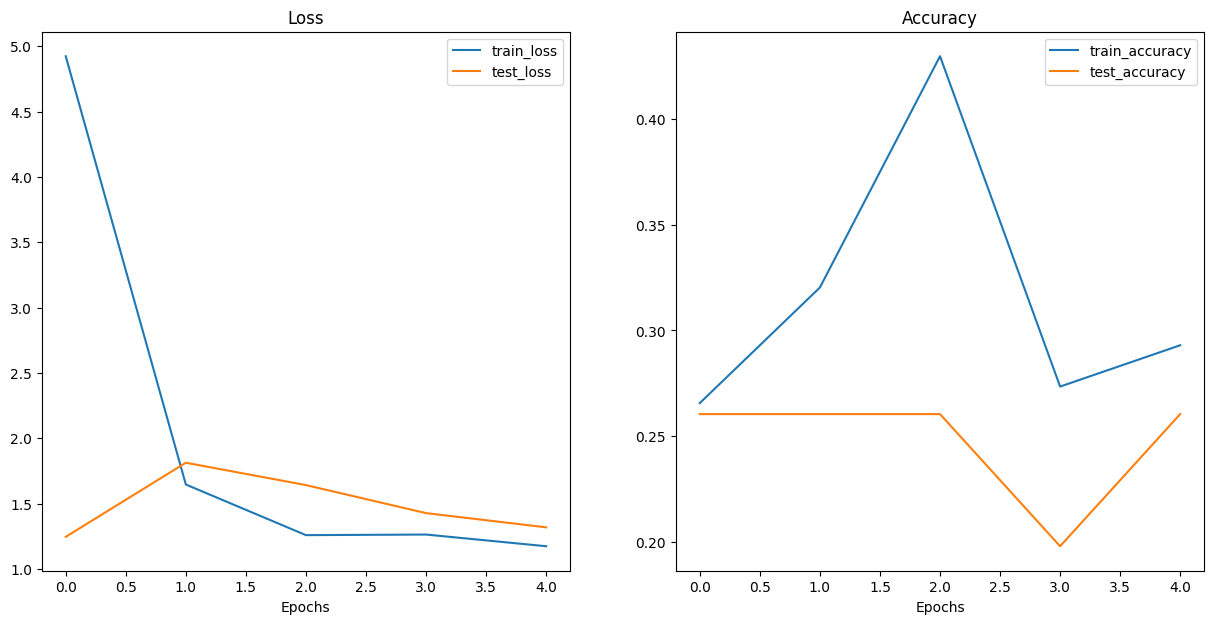

In [37]:
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

In [39]:
#using a pretrained model
#get weights
pretrained_vit_weights=torchvision.models.ViT_B_16_Weights.DEFAULT

#get model
pretrained_vit=torchvision.models.vit_b_16(weights=pretrained_vit_weights)


#get an idea of the archtecture
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)





Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:05<00:00, 60.8MB/s]


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 1000]           768                  True
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              True
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       7,087,872            True
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 197, 76

In [41]:
# freeze all layers
for parameter in pretrained_vit.parameters():
  parameter.requires_grad =False

pretrained_vit.heads=nn.Linear(in_features=768, out_features=len(class_names)).to(device)

summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [43]:
# get the transform on the image
model_transform=pretrained_vit_weights.transforms()
print(model_transform)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [44]:
# prepare train and test dataloader

train_dataloader, test_dataloader, class_names=data_setup.create_dataloaders(
    train_dir =train_dir,
    test_dir=test_dir,
    transform=model_transform,
    batch_size=BATCH_SIZE
)

In [45]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader,
                                      test_dataloader=test_dataloader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 0.6978 | train_acc: 0.7969 | test_loss: 0.4399 | test_acc: 0.9280
Epoch: 2 | train_loss: 0.3117 | train_acc: 0.9492 | test_loss: 0.2633 | test_acc: 0.9384
Epoch: 3 | train_loss: 0.1909 | train_acc: 0.9609 | test_loss: 0.2201 | test_acc: 0.9280
Epoch: 4 | train_loss: 0.1442 | train_acc: 0.9648 | test_loss: 0.2002 | test_acc: 0.9280
Epoch: 5 | train_loss: 0.1172 | train_acc: 0.9688 | test_loss: 0.1932 | test_acc: 0.9280
Epoch: 6 | train_loss: 0.1279 | train_acc: 0.9727 | test_loss: 0.1866 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0887 | train_acc: 0.9805 | test_loss: 0.2155 | test_acc: 0.9384
Epoch: 8 | train_loss: 0.0776 | train_acc: 0.9844 | test_loss: 0.2075 | test_acc: 0.9384
Epoch: 9 | train_loss: 0.1057 | train_acc: 0.9883 | test_loss: 0.1866 | test_acc: 0.9280
Epoch: 10 | train_loss: 0.0618 | train_acc: 0.9883 | test_loss: 0.1713 | test_acc: 0.9176


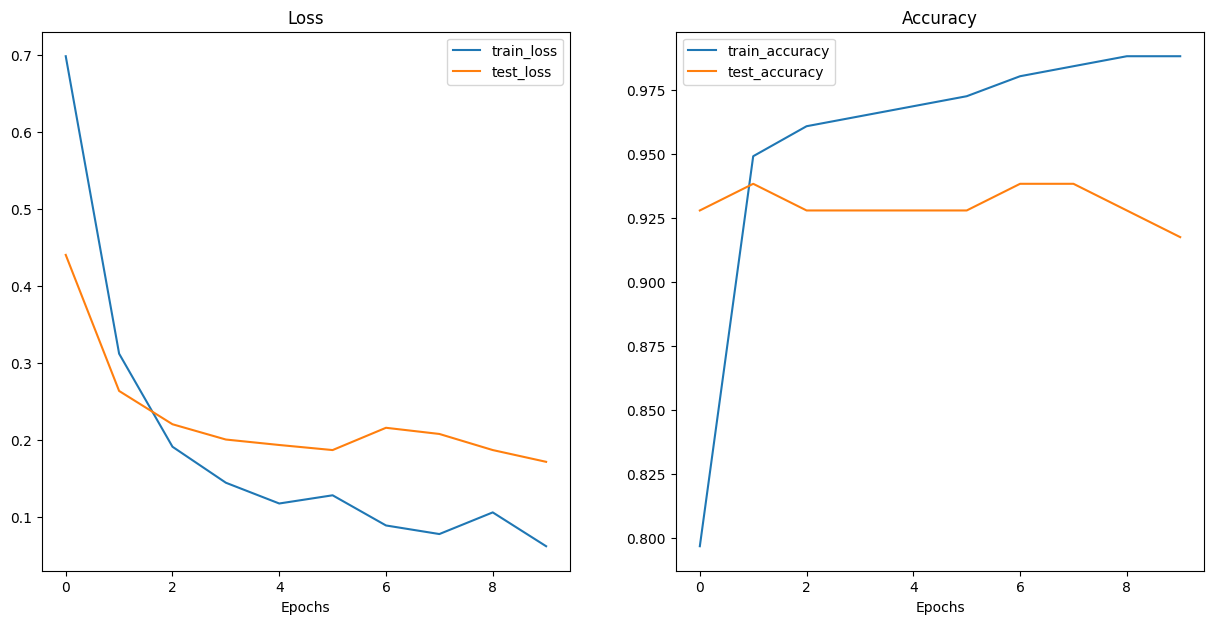

In [46]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

In [47]:
# Save pretrained model
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir='models',
                 model_name='pretrained_vit_pizza.pth')

[INFO] Saving model to: models/pretrained_vit_pizza.pth
